In [1]:
%matplotlib inline

In [1]:
import os
import numpy as np
import pandas as pd
import music21 as m21
from typing import List
from itertools import product
from collections import defaultdict
from sklearn.externals import joblib
from matplotlib import pyplot as plt
from scipy import sparse
from easy_ml.tools.util import download_from_gcs

In [2]:
from scipy.stats.distributions import bernoulli
from sklearn import datasets

In [3]:
num_classes=2

In [72]:
X, y = datasets.make_classification(n_samples=1000,
                            n_features=5,
                             n_informative=5,
                            n_redundant=0)
X = np.hstack([X, np.ones((X.shape[0], 1))])
beta_init = np.random.uniform(-1, 1, size=(num_classes-1, X.shape[1]))

http://econ.queensu.ca/ETM/corrections/Fourth-pdf/pg468.pdf

In [73]:
def log_likelihood(beta):
    theta_dot_x = beta.dot(X.T)
    log_prob_data_given_theta = y * theta_dot_x - np.log(1 + np.exp(theta_dot_x))
    return np.sum(log_prob_data_given_theta)

In [74]:
log_likelihood(beta_init)

-1760.2558768216836

In [75]:
def predicted_probabilities(beta):
    exp_log_odds = np.exp(np.dot(beta, X.T)).T
    return (1 / (1 + exp_log_odds)).ravel()

def score_function(beta, probabilities, lmbda):
    return np.dot(X.T, (y - probabilities)) + lmbda*beta

def hessian(beta, probabilities, lmbda):
    W = np.eye(X.shape[0])
    for i in range(W.shape[0]):
        W[i,i] = probabilities[i] * (1 - probabilities[i])
    return X.T.dot(W).dot(X) + lmbda*np.eye(X.shape[1])

In [76]:
def newton_step(beta, lmbda):
    probs = predicted_probabilities(beta)
    score = score_function(beta, probs, lmbda)
    hess = hessian(beta, probs, lmbda)
    step = np.linalg.inv(hess).dot(score.T).ravel()
    return (beta - step).reshape(beta.shape)

In [77]:
def newton_raphson(beta_init, lmbda=0.1, num_iter=10):
    ll = []
    current_beta = beta_init
    for i in range(num_iter):
        log_lik = log_likelihood(current_beta)
        ll.append(log_lik)
        current_beta = newton_step(current_beta, lmbda)
    return current_beta, ll

In [78]:
fitted, ll = newton_raphson(beta_init, 10)

In [102]:
score_function(beta_init, predicted_probabilities(beta_init), 1).shape

(1, 6)

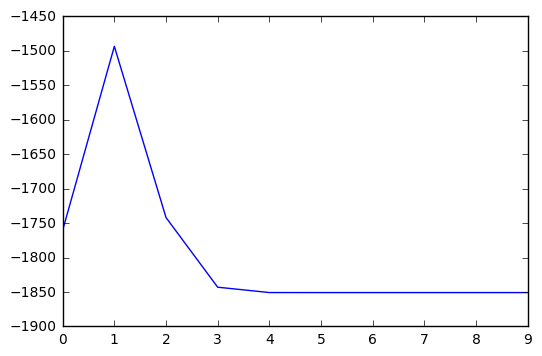

In [79]:
plt.plot(ll)

In [80]:
fitted

array([[ 0.83479516,  0.73530702,  0.67845155,  0.07134064,  0.13444748,
         0.6847453 ]])

In [62]:
from sklearn.linear_model import LogisticRegression

In [81]:
lr = LogisticRegression(fit_intercept=False)

In [82]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [83]:
lr.coef_

array([[-0.95400494, -0.84201503, -0.7050434 , -0.06192847, -0.10719174,
        -0.86798087]])

In [84]:
fitted

array([[ 0.83479516,  0.73530702,  0.67845155,  0.07134064,  0.13444748,
         0.6847453 ]])

In [85]:
pred = (predicted_probabilities(fitted) >= 0.5).astype(int)

In [86]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [87]:
accuracy_score(y, pred)

0.82299999999999995

In [88]:
confusion_matrix(y, pred)

array([[405,  94],
       [ 83, 418]])

(array([ 177.,  104.,   80.,   65.,   62.,   61.,   76.,   73.,  129.,  173.]),
 array([ 0.00152243,  0.10128042,  0.20103841,  0.30079639,  0.40055438,
         0.50031237,  0.60007036,  0.69982834,  0.79958633,  0.89934432,
         0.99910231]),
 <a list of 10 Patch objects>)

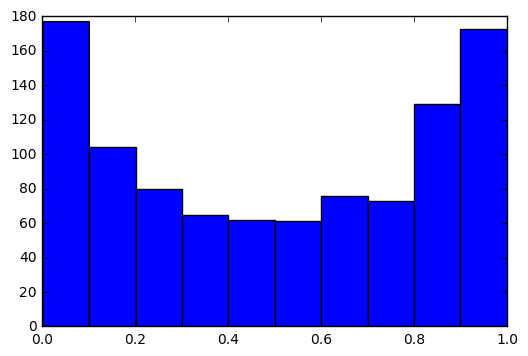

In [89]:
plt.hist(predicted_probabilities(fitted))

http://sites.stat.psu.edu/~jiali/course/stat597e/notes2/logit.pdf

# Modeling Composer

In [96]:
labeled_corpus = joblib.load('/home/jovyan/persistent_data/data/dumps/labeled_corpus.pkl')

AttributeError: shape not found